In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
DATA_DIR = '/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/ERI/'
VIDEO_DIR=DATA_DIR+'raw/'
AUDIO_DIR=DATA_DIR+'audio/'
FRAMES_DIR=DATA_DIR+'frames/'
FACES_DIR=DATA_DIR+'face_images/'
TRAIN_LABELS=DATA_DIR+'train_split.csv'
VAL_LABELS=DATA_DIR+'valid_split.csv'

TEST_DATA_DIR = DATA_DIR+'test_data/'
TEST_VIDEO_DIR=TEST_DATA_DIR+'raw/'
TEST_AUDIO_DIR=TEST_DATA_DIR+'audio/'
TEST_FRAMES_DIR=TEST_DATA_DIR+'frames/'
TEST_FACES_DIR=TEST_DATA_DIR+'face_images/'

In [3]:
import os
from PIL import Image
import cv2
import pathlib

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score,roc_auc_score,average_precision_score

from collections import defaultdict
import os
import glob
import random
import numpy as np
from tqdm import tqdm
import time
import pickle
import pandas as pd
import random
import csv  
import matplotlib.pyplot as plt

In [4]:
def get_names(id):
    name = ""
    if id>=0 and id<10:
        name = "0000" + str(id)
    elif id>=10 and id<100:
        name = "000" + str(id)
    elif id>=100 and id<1000:
        name = "00" + str(id)
    elif id>=1000 and id<10000:
        name = "0" + str(id)
    else:
        name = str(id)
    return name

In [5]:
compare_filenames=lambda x: int(os.path.splitext(x)[0])

# Extract features

In [9]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

print(f"Torch: {torch.__version__}")
device = 'cuda'
use_cuda = torch.cuda.is_available()
print(use_cuda)

Torch: 2.0.1+cu118
True


In [10]:
if True:
    if False:
        model_name='mbf_va_mtl.pt'

        IMG_SIZE=112

        test_transforms = transforms.Compose(
        [
            transforms.Resize((112,112)),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
        ]
        )

        import sys
        sys.path.append("/home/avsavchenko/src/distr/insightface/recognition/arcface_torch/backbones/")
        import mobilefacenet
    else:
        if False:
            #model_name='affectnet_vggface2_enet2_gmp_smooth.pt'
            model_name='enet_b2_8_best.pt'
            #model_name='enet_b2_7.pt'
            IMG_SIZE=260 #224 #
        else:
            #model_name='affectnet_vggface2_enet0.pt'
            #model_name='affectnet_vggface2_enet0_new.pt'
            #model_name='enet_b0_7.pt'
            #model_name='enet_b0_8_best_afew.pt'
            #model_name='enet_b0_8_best_vgaf.pt'
            model_name='enet_b0_8_va_mtl.pt'
            #model_name='mobilevit_va_mtl.pt'

            IMG_SIZE=224

        #IMG_SIZE=112

        test_transforms = transforms.Compose(
            [
                transforms.Resize((IMG_SIZE,IMG_SIZE)),
                #transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
            ]
        )
        np_transforms = transforms.Compose(
            [
                transforms.ToPILImage(None),
                transforms.Resize((IMG_SIZE,IMG_SIZE)),
                #transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
            ]
        )


    print(model_name)
    feature_extractor_model = torch.load('/home/avsavchenko/src/face-emotion-recognition/models/affectnet_emotions/'+model_name)

else:
    IMG_SIZE=112
    
    test_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])  
    
    import sys
    DDAMNFN_PATH='/home/avsavchenko/src/distr/DDAMFN'
    sys.path.append(DDAMNFN_PATH)
    from networks.DDAM import DDAMNet

    if True:
        feature_extractor_model = DDAMNet(num_class=8, num_head=2)
        model_name='affectnet8_epoch4_acc0.6462'
    else:
        feature_extractor_model = DDAMNet(num_class=10, num_head=2)
        model_name='affectnet8_epoch9_acc0.642_mtl_2'
    feature_extractor_model.load_state_dict(torch.load(DDAMNFN_PATH+'/checkpoints/'+model_name+'.pth')['model_state_dict'])
    feature_extractor_model.bn=torch.nn.Identity()
    print(model_name)

In [12]:
feature_extractor_model

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=

In [13]:
if False:
    classifier_weights=feature_extractor_model.classifier[0].weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.classifier[0].bias.cpu().data.numpy()
elif True:
    classifier_weights=feature_extractor_model.classifier.weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.classifier.bias.cpu().data.numpy()
elif False:
    classifier_weights=feature_extractor_model.head.fc.weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.head.fc.bias.cpu().data.numpy()
else:
    classifier_weights=feature_extractor_model.fc.weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.fc.bias.cpu().data.numpy()
print(classifier_weights.shape,classifier_weights)
print(classifier_bias.shape,classifier_bias)

(10, 1280) [[ 0.00679121  0.09001139  0.0694934  ...  0.10351563 -0.00995514
  -0.17376047]
 [-0.004085   -0.07134113 -0.12164655 ... -0.05029012  0.03059323
   0.08198261]
 [-0.0034241  -0.06510569 -0.00448079 ...  0.04248156 -0.10535879
  -0.00544419]
 ...
 [ 0.07878461 -0.03540913 -0.06665969 ... -0.10314589  0.1332206
  -0.06119434]
 [-0.02409821 -0.00270485  0.00887998 ... -0.00501176  0.01345664
  -0.02131553]
 [-0.04529824 -0.04590099 -0.00950194 ...  0.00753843  0.02128105
  -0.05743075]]
(10,) [-0.03629377 -0.00268708 -0.05411524  0.01482256  0.13788255  0.09921926
 -0.05259513 -0.0124341   0.0816549   0.04621203]


In [14]:
if True:
    feature_extractor_model.classifier=torch.nn.Identity()
elif False:
    feature_extractor_model.head.fc=torch.nn.Identity()
else:
    feature_extractor_model.fc=torch.nn.Identity()
feature_extractor_model=feature_extractor_model.to(device)
feature_extractor_model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=

In [15]:
def get_probab(features):
    x=np.dot(features,np.transpose(classifier_weights))+classifier_bias
    return x

In [ ]:
print(test_transforms)
data_dir=FACES_DIR
print(data_dir)

videoname2features,videoname2scores={},{}
for videoname in sorted(os.listdir(data_dir)):
    video_dir=os.path.join(data_dir,videoname)   
    print(videoname)
    X_features,img_names=[],[]
    imgs=[]
    for img_name in sorted(os.listdir(video_dir), key=compare_filenames)[::5]:
        #print(video_dir,img_name)
        img = Image.open(os.path.join(video_dir,img_name))
        img_tensor = test_transforms(img)
        if img.size:
            img_names.append(videoname+'/'+img_name)
            imgs.append(img_tensor)
            if len(imgs)>=64: #96: #48: #32:        
                #features,_,_ = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                features=features.data.cpu().numpy()
                #print(features.shape)

                if len(X_features)==0:
                    X_features=features
                else:
                    X_features=np.concatenate((X_features,features),axis=0)
                imgs=[]
    #if videoname=='00002':
    #    break

    if len(imgs)>0:        
        #features,_,_ = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
        features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
        features=features.data.cpu().numpy()

        if len(X_features)==0:
            X_features=features
        else:
            X_features=np.concatenate((X_features,features),axis=0)

        imgs=[]
    if len(X_features)>0:
        X_scores=get_probab(X_features)
        print(X_features.shape,X_scores.shape)
        videoname2features[videoname]=X_features
        videoname2scores[videoname]=X_scores

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/ERI/detected_faces/


  0%|          | 0/12660 [00:00<?, ?it/s]

### Save/load features 

In [82]:
import pickle
if False:
    #model_name='enet_b2_8_best'
    #model_name='enet_b0_8_best_vgaf'
    model_name='ddamfnet_8'
    has_va=False
else:
    #model_name='enet_b0_8_va_mtl'
    #model_name='mobilevit_va_mtl'
    #model_name='mbf_va'
    model_name='ddamfnet_mtl'
    has_va=True
    
#MODEL2FEATURES='eri_dict_'+model_name+'.pickle' 

MODEL2FEATURES='eri_'+model_name+'_orig_faces.pickle' 
#MODEL2FEATURES='eri_ddamfnet_mtl_orig_faces.pickle'
#MODEL2FEATURES='eri_mbf_va_orig_faces.pickle'
#MODEL2FEATURES='eri_mobilevit_va_mtl_orig_faces.pickle'

print(MODEL2FEATURES)

eri_ddamfnet_mtl_orig_faces.pickle


In [ ]:
if False:
    with open(MODEL2FEATURES, 'wb') as handle:
        pickle.dump([videoname2features,videoname2scores], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [83]:
filename=MODEL2FEATURES
with open(filename, 'rb') as handle:
    videoname2features,videoname2scores=pickle.load(handle)
print(len(videoname2features),videoname2features['00001'].shape,videoname2scores['00001'].shape)

17255 (39, 512) (39, 10)


In [76]:
filename='eri_test_'+model_name+'_orig_faces.pickle'
print(filename)
with open(filename, 'rb') as handle:
    videoname2features_test,videoname2scores_test=pickle.load(handle)
print(len(videoname2features_test),videoname2features_test['12660'].shape,videoname2scores_test['12660'].shape)

eri_test_ddamfnet_mtl_orig_faces.pickle
4586 (39, 512) (39, 10)


### Audio

In [6]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torchaudio
import torch

In [7]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [12]:
array, fs = torchaudio.load(os.path.join(AUDIO_DIR,'00000.mp3'))
print(fs)
inp = processor(array.squeeze(), sampling_rate=fs, return_tensors="pt")

# apply the model to the input array from wav
with torch.no_grad():
    outputs = model(**inp)

# extract last hidden state, compute average, convert to numpy
last_hidden_states = outputs.last_hidden_state.squeeze().mean(axis=0).numpy()

# change to list to print
print(f"Hidden state shape: {last_hidden_states.shape} {outputs.last_hidden_state.shape}")
# Hidden state shape: (768,)

16000
Hidden state shape: (768,) torch.Size([1, 294, 768])


In [14]:
videoname2features={}
for filename in tqdm(sorted(os.listdir(AUDIO_DIR))):
    videoname,_=os.path.splitext(filename)
    #print(videoname)
    array, fs = torchaudio.load(os.path.join(AUDIO_DIR,filename))
    inp = processor(array.squeeze(), sampling_rate=fs, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inp)
    videoname2features[videoname]=outputs.last_hidden_state.numpy()[0]
    #print(videoname2features[videoname].shape)

100%|██████████| 965/965 [03:22<00:00,  4.76it/s]


In [16]:
len(videoname2features),videoname2features['11694'].shape

(12660, (62495, 768))

In [9]:
MODEL2AUDIOFEATURES='eri_dict_wav2vec2.pickle'
#MODEL2AUDIOFEATURES='eri_dict_mobilevit_frames.pickle'
#MODEL2AUDIOFEATURES='eri_mbf_vggface2_orig_faces.pickle'

if False:
    with open(MODEL2AUDIOFEATURES, 'wb') as handle:
        pickle.dump(videoname2audio_features, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(MODEL2AUDIOFEATURES, 'rb') as handle:
        videoname2audio_features=pickle.load(handle)
print(len(videoname2audio_features),videoname2audio_features['00001'].shape)

12660 (306, 768)


In [ ]:
import wave, struct
from fnmatch import fnmatch
for filename in tqdm(os.listdir(TEST_VIDEO_DIR)):
    #print(filename)
    video_path=os.path.join(TEST_VIDEO_DIR,filename)
    fn=os.path.splitext(filename)[0]
    waveFile = os.path.join(TEST_AUDIO_DIR, fn+'.wav')
    command = "ffmpeg -i "+video_path+" -ac 1 -ar 16000 -vn "+waveFile
    #print(command)
    os.system(command=command)

In [ ]:
videoname2audio_features_test={}
for filename in sorted(os.listdir(TEST_AUDIO_DIR)):
    videoname,_=os.path.splitext(filename)
    array, fs = torchaudio.load(os.path.join(TEST_AUDIO_DIR,filename))
    inp = processor(array.squeeze(), sampling_rate=fs, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inp)
    videoname2audio_features_test[videoname]=outputs.last_hidden_state.numpy()[0]
    print(videoname,videoname2audio_features_test[videoname].shape)

In [10]:
MODEL2AUDIOFEATURES='eri_test_wav2vec2.pickle'

if False:
    with open(MODEL2AUDIOFEATURES, 'wb') as handle:
        pickle.dump(videoname2audiofeatures, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(MODEL2AUDIOFEATURES, 'rb') as handle:
        videoname2audio_features_test=pickle.load(handle)
print(len(videoname2audio_features_test),videoname2audio_features_test['12660'].shape)

4586 (305, 768)


# Preprocess data

In [88]:
def get_video2targets(videoname2features,filename):
    num_missed=0
    X,y=[],[]
    with open(os.path.join(DATA_DIR,filename)) as f:
        lines = f.read().splitlines()
        for i,line in enumerate(lines):
            if i>0:
                splitted_line=line.split(',')
                videoname=splitted_line[0]
                if videoname in videoname2features:
                    features=videoname2features[videoname]

                    mean_features=features.mean(axis=0)
                    std_features=features.std(axis=0)
                    min_features=features.min(axis=0)
                    max_features=features.max(axis=0)
                    aggregated_feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)
                    #aggregated_feature=mean_features

                    X.append(aggregated_feature)

                    targets=[float(s) for s in splitted_line[1:]]
                    y.append(targets)
                else:
                    num_missed+=1
                    print('Missed:',videoname)
        X=np.array(X)
        y=np.array(y)
        print(X.shape,y.shape,num_missed)
        return X,y

if True:
    X_train,y_train=get_video2targets(videoname2scores,TRAIN_LABELS)
    X_val,y_val=get_video2targets(videoname2scores,VAL_LABELS)
else:
    #Audio
    X_train,y_train=get_video2targets(videoname2audio_features,TRAIN_LABELS)
    X_val,y_val=get_video2targets(videoname2audio_features,VAL_LABELS)

TRAIN_VAL=False

(8072, 40) (8072, 6) 0
(4588, 40) (4588, 6) 0


In [96]:
if True:
    TRAIN_VAL=True
    X_train=np.concatenate((X_train,X_val))
    y_train=np.concatenate((y_train,y_val))
    print(X_train.shape,y_train.shape)

(12660, 40) (12660, 6)


In [12]:
classes=['Admiration','Amusement','Determination','Empathic Pain','Excitement','Joy']
num_classes=len(classes)
print(classes,num_classes)

['Admiration', 'Amusement', 'Determination', 'Empathic Pain', 'Excitement', 'Joy'] 6


<Figure size 216x216 with 0 Axes>

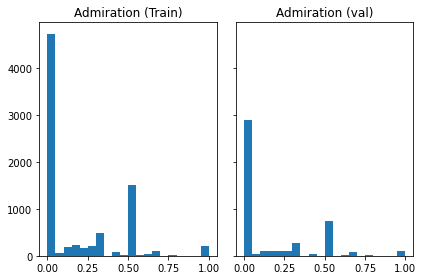

<Figure size 216x216 with 0 Axes>

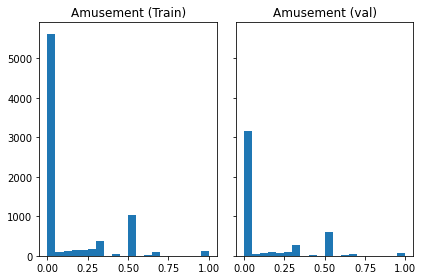

<Figure size 216x216 with 0 Axes>

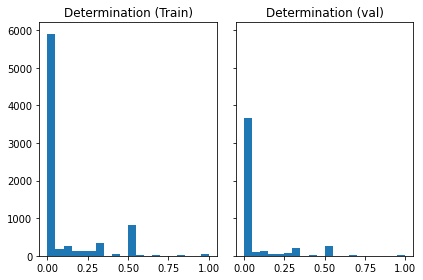

<Figure size 216x216 with 0 Axes>

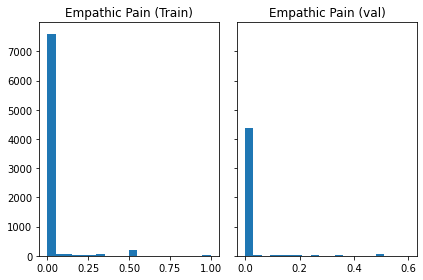

<Figure size 216x216 with 0 Axes>

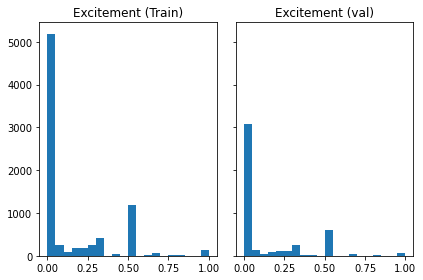

<Figure size 216x216 with 0 Axes>

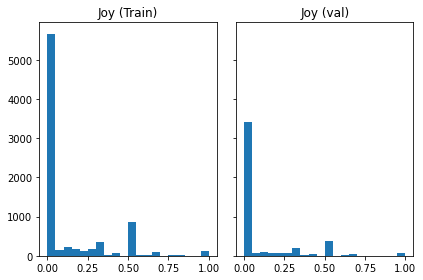

In [10]:
for i, cls in enumerate(classes):
    plt.figure(figsize=(3, 3))
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    axs[0].hist(y_train[:,i], bins=20)
    axs[0].set_title(cls+' (Train)')
    axs[1].hist(y_val[:,i], bins=20)
    axs[1].set_title(cls+' (val)')

# Learning

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential, load_model,model_from_json
from tensorflow.keras.applications import mobilenet,mobilenet_v2,densenet,inception_resnet_v2,inception_v3,vgg16,resnet_v2,resnet
import efficientnet.tfkeras as enet
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D,Activation, Conv2D, Reshape,DepthwiseConv2D,Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, CSVLogger, EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow.keras.backend as K 

print(tf.__version__)
from tensorflow.compat.v1.keras.backend import set_session 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

2.13.1


In [14]:
from copy import deepcopy
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_model_weights = deepcopy(self.model.get_weights())

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_model_weights = deepcopy(self.model.get_weights())

In [15]:
def CCC_score(x, y):
    vx = x - np.mean(x)
    vy = y - np.mean(y)
    rho = np.sum(vx * vy) / (np.sqrt(np.sum(vx**2)) * np.sqrt(np.sum(vy**2)))
    x_m = np.mean(x)
    y_m = np.mean(y)
    x_s = np.std(x)
    y_s = np.std(y)
    ccc = 2*rho*x_s*y_s/(x_s**2 + y_s**2 + (x_m - y_m)**2)
    return ccc


def CCC_numpy(y_true, y_pred):
    '''Reference numpy implementation of Lin's Concordance correlation coefficient'''
    
    # covariance between y_true and y_pred
    s_xy = np.cov([y_true, y_pred])[0,1]
    # means
    x_m = np.mean(y_true)
    y_m = np.mean(y_pred)
    # variances
    s_x_sq = np.var(y_true)
    s_y_sq = np.var(y_pred)
    
    # condordance correlation coefficient
    ccc = (2.0*s_xy) / (s_x_sq + s_y_sq + (x_m-y_m)**2)
    
    return ccc

def CCC(y_true, y_pred):
    '''Lin's Concordance correlation coefficient: https://en.wikipedia.org/wiki/Concordance_correlation_coefficient
    
    The concordance correlation coefficient is the correlation between two variables that fall on the 45 degree line through the origin.
    
    It is a product of
    - precision (Pearson correlation coefficient) and
    - accuracy (closeness to 45 degree line)

    Interpretation:
    - `rho_c =  1` : perfect agreement
    - `rho_c =  0` : no agreement
    - `rho_c = -1` : perfect disagreement 
    
    Args: 
    - y_true: ground truth
    - y_pred: predicted values
    
    Returns:
    - concordance correlation coefficient (float)
    '''
    
    
    # covariance between y_true and y_pred
    #N = K.int_shape(y_pred)[-1]
    #s_xy = 1.0 / (N - 1.0 + K.epsilon()) * K.sum((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred)))
    #s_xy = K.mean(K.sum((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred))))
    s_xy = K.mean((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred)))
    # means
    x_m = K.mean(y_true)
    y_m = K.mean(y_pred)
    # variances
    s_x_sq = K.var(y_true)
    s_y_sq = K.var(y_pred)
    
    # condordance correlation coefficient
    ccc = (2.0*s_xy) / (s_x_sq + s_y_sq + (x_m-y_m)**2+K.epsilon())
    #print(s_xy,s_x_sq,s_y_sq,x_m,y_m)
    return ccc

def CCC_ERI(y_true, y_pred):
    loss=0
    #print(y_true.shape,y_pred.shape)
    for i in range(num_classes):
        loss+=CCC(y_true[:,i], y_pred[:,i])
    return 1-loss/num_classes

from scipy import stats 
import numpy as np

def calc_pearsons(preds,labels):
    r = stats.pearsonr(preds, labels)
    return r[0]

def mean_pearsons(preds,labels):
    preds = np.row_stack([np.array(p) for p in preds])
    labels = np.row_stack([np.array(l) for l in labels])
    num_classes = preds.shape[1]
    class_wise_r = np.array([calc_pearsons(preds[:,i], labels[:,i]) for i in range(num_classes)])
    mean_r = np.mean(class_wise_r)
    return mean_r, class_wise_r

In [16]:
#counts=np.array([0.04752795, 0.25179336, 0.12408552, 0.08759098, 0.24792852, 0.28702279])
counts=np.array([1, 8, 4, 2, 8, 8])
class_weights=1/counts
class_weights/=class_weights.sum()
class_weights_sum=class_weights.sum()
print(class_weights,class_weights_sum)

[0.47058824 0.05882353 0.11764706 0.23529412 0.05882353 0.05882353] 1.0


In [17]:
def Pearson(y_true, y_pred):
    # covariance between y_true and y_pred
    #N = K.int_shape(y_pred)[-1]
    #s_xy = 1.0 / (N - 1.0 + K.epsilon()) * K.sum((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred)))
    #s_xy = K.mean(K.sum((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred))))
    s_xy = K.mean((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred)))
    # variances
    s_x_sq = K.std(y_true)
    s_y_sq = K.std(y_pred)
    
    # pearson correlation coefficient
    pcc = (s_xy) / (s_x_sq * s_y_sq + K.epsilon())
    return pcc

def Pearson_ERI_loss(y_true, y_pred):
    loss=0
    #print(y_true.shape,y_pred.shape)
    for i in range(y_true.shape[1]):
        loss+=Pearson(y_true[:,i], y_pred[:,i])# *class_weights[i]
    return 1-loss/y_true.shape[1]#+0.1*K.binary_crossentropy(y_true, y_pred)

def Pearson_ERI_loss_weighted(y_true, y_pred):
    loss=0
    for i in range(y_true.shape[1]):
        loss+=Pearson(y_true[:,i], y_pred[:,i]) *class_weights[i]
    return 1-loss


def ProdLoss(y_true, y_pred):
    return K.mean(y_true  * y_pred)

def Prod_ERI_loss(y_true, y_pred):
    loss=0
    for i in range(y_true.shape[1]):
        loss+=ProdLoss(y_true[:,i], y_pred[:,i]) *class_weights[i]
    return 1-loss/y_true.shape[1]

def correlation(x, y):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return r_num / r_den

def pearson_correlation(y_true, y_pred):
    r=0
    for i in range(y_true.shape[1]):
        r+=correlation(y_true[:,i], y_pred[:,i])
    return r/y_true.shape[1]


In [18]:
def print_metrics():
    y_val_preds=mlpModel.predict(X_val,verbose=0)
    print(mean_pearsons(y_val_preds,y_val))

In [19]:
if True:
    loss='binary_crossentropy'
    #loss='hinge'
else:
    import tensorflow.keras.backend as K
    def get_weighted_loss(weights):
        def weighted_loss(y_true, y_pred):
            y_true=tf.cast(y_true, tf.float32)
            ce=K.binary_crossentropy(y_true, y_pred)
            return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*ce, axis=-1)
        return weighted_loss
    loss=get_weighted_loss(class_weights)

In [20]:
from tensorflow.keras import backend as K
def relu_advanced(x):
    return K.relu(x, max_value=1)

In [99]:
batch_size=512 #128 #1024 #
mlpModel=Sequential()
mlpModel.add(Dense(64, input_shape=X_train.shape[1:],activation='relu')) #256
mlpModel.add(Dense(num_classes,activation='sigmoid'))
    
#mlpModel.compile(optimizer=Adam(learning_rate=1e-3), loss=CCC_ERI, metrics=[correlation]) #'mae','mse'
#mlpModel.compile(optimizer=Adam(learning_rate=1e-3), loss=Prod_ERI_loss, metrics=[pearson_correlation])
#mlpModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=Pearson_ERI_loss, metrics=[pearson_correlation])
mlpModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=Pearson_ERI_loss_weighted, metrics=[pearson_correlation])
#mlpModel.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=[pearson_correlation])
#mlpModel.compile(optimizer=Adam(learning_rate=1e-3), loss=loss, metrics=[pearson_correlation])
mlpModel.summary()

#save_best_model = SaveBestModel('val_loss',False)
save_best_model = SaveBestModel('val_pearson_correlation',True)
mlpModel.fit(X_train,y_train, batch_size=batch_size, epochs=20, verbose=1, callbacks=[save_best_model], validation_data=(X_val,y_val))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

print_metrics()
print('Best weights:')
mlpModel.set_weights(best_model_weights)
print_metrics()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                2624      
                                                                 
 dense_15 (Dense)            (None, 6)                 390       
                                                                 
Total params: 3014 (11.77 KB)
Trainable params: 3014 (11.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
25/25 [==============================] - 2s 22ms/step - loss: 1.0031 - pearson_correlation: 0.0276 - val_loss: 0.9543 - val_pearson_correlation: 0.0800
Epoch 2/20
25/25 [==============================] - 0s 11ms/step - loss: 0.9277 - pearson_correlation: 0.1107 - val_loss: 0.9116 - val_pearson_correlation: 0.1334
Epoch 3/20
25/25 [==============================] - 0s 12ms/step - loss: 0.9013 - pearson

In [100]:
batch_size=512 #128 #1024 #
mlpModel=Sequential()

#mlpModel.add(Dense(num_classes, input_shape=X_train.shape[1:],activation='tanh',use_bias=True,kernel_regularizer=tf.keras.regularizers.l2(1.0/batch_size)))
mlpModel.add(Dense(num_classes, input_shape=X_train.shape[1:],activation='sigmoid',use_bias=True,kernel_regularizer=tf.keras.regularizers.l2(1.0/batch_size)))
    
#mlpModel.compile(optimizer=Adam(learning_rate=1e-3), loss=CCC_ERI, metrics=[correlation]) #'mae','mse'
#mlpModel.compile(optimizer=Adam(learning_rate=1e-3), loss=Prod_ERI_loss, metrics=[pearson_correlation])
#mlpModel.compile(optimizer=Adam(learning_rate=1e-3), loss=loss, metrics=[pearson_correlation])

#mlpModel.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=[pearson_correlation])
mlpModel.compile(optimizer=Adam(learning_rate=1e-3), loss=Pearson_ERI_loss, metrics=[pearson_correlation])
#mlpModel.compile(optimizer=Adam(learning_rate=1e-3), loss=Pearson_ERI_loss_weighted, metrics=[pearson_correlation])


mlpModel.summary()

#save_best_model = SaveBestModel('val_loss',False)
save_best_model = SaveBestModel('val_pearson_correlation',True)
mlpModel.fit(X_train,y_train, batch_size=batch_size, epochs=100, verbose=1, callbacks=[save_best_model], validation_data=(X_val,y_val))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

print_metrics()
print('Best weights:')
mlpModel.set_weights(best_model_weights)
print_metrics()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 6)                 246       
                                                                 
Total params: 246 (984.00 Byte)
Trainable params: 246 (984.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 2s 22ms/step - loss: 1.0258 - pearson_correlation: -0.0061 - val_loss: 0.9922 - val_pearson_correlation: 0.0269
Epoch 2/100
25/25 [==============================] - 0s 11ms/step - loss: 0.9823 - pearson_correlation: 0.0373 - val_loss: 0.9526 - val_pearson_correlation: 0.0657
Epoch 3/100
25/25 [==============================] - 0s 12ms/step - loss: 0.9482 - pearson_correlation: 0.0701 - val_loss: 0.9284 - val_pearson_correlation: 0.0893
Epoch 4/100
25/25 [==============================]

Epoch 97/100
25/25 [==============================] - 0s 11ms/step - loss: 0.8124 - pearson_correlation: 0.1902 - val_loss: 0.8057 - val_pearson_correlation: 0.1966
Epoch 98/100
25/25 [==============================] - 0s 12ms/step - loss: 0.8119 - pearson_correlation: 0.1905 - val_loss: 0.8058 - val_pearson_correlation: 0.1966
Epoch 99/100
25/25 [==============================] - 0s 11ms/step - loss: 0.8120 - pearson_correlation: 0.1905 - val_loss: 0.8048 - val_pearson_correlation: 0.1975
Epoch 100/100
25/25 [==============================] - 0s 11ms/step - loss: 0.8120 - pearson_correlation: 0.1903 - val_loss: 0.8055 - val_pearson_correlation: 0.1968
0.19748176634311676
(0.19678219453484558, array([0.10060672, 0.27729754, 0.14392887, 0.09481543, 0.2646922 ,
       0.29935241]))
Best weights:
(0.19750310533254925, array([0.10209893, 0.27784445, 0.14552538, 0.09495002, 0.2645854 ,
       0.30001444]))


In [91]:
y_val_preds=mlpModel.predict(X_val,verbose=0)
print(mean_pearsons(y_val_preds,y_val))
def correlation_np(x, y):    
    mx = np.mean(x)
    my = np.mean(y)
    xm, ym = x-mx, y-my
    r_num = np.mean(np.multiply(xm,ym))        
    r_den = np.std(xm) * np.std(ym)
    return r_num / r_den
print(correlation_np(y_val_preds,y_val))

(0.1723227638265419, array([0.03896451, 0.24999949, 0.12893387, 0.0788345 , 0.254864  ,
       0.28234021]))
0.1424794447778636


In [33]:
if False:
    mlpModel.save_weights('eri_mbf_va_face_images.h5')#(0.18358024829438388, array([0.07515647, 0.25664032, 0.12777257, 0.10387064, 0.25493754,0.28310395]))
    #mlpModel.save_weights('eri_ddamfnet_mtl_face_images.h5')#(0.17381719697341094, array([0.05892773, 0.26441864, 0.12007343, 0.06789432, 0.24262809,0.28896098]))
    #(0.18164753736100603, array([0.06823453, 0.25565953, 0.12300463, 0.10762958, 0.2540667 ,       0.28129026]))
    #mlpModel.save_weights('eri_audio.h5')#(0.2361361954257474, array([0.30001496, 0.1883828 , 0.2457414 , 0.31087313, 0.22221633, 0.14958856]))
else:
    mlpModel.load_weights('eri_audio.h5')
    #mlpModel.load_weights('eri_mbf_va_face_images.h5')
    print_metrics()

(0.2361361954257474, array([0.30001496, 0.1883828 , 0.2457414 , 0.31087313, 0.22221633,
       0.14958856]))


In [92]:
#mlpModel.load_weights('eri_mbf_va_face_images.h5')
mlpModel.load_weights('eri_ddamfnet_mtl_face_images.h5')
y_val_preds=mlpModel.predict(X_val,verbose=0)
print(mean_pearsons(y_val_preds,y_val))

(0.17381719697341094, array([0.05892773, 0.26441864, 0.12007343, 0.06789432, 0.24262809,
       0.28896098]))


In [22]:
#mlpModel.load_weights('eri_audio.h5')
y_val_preds_audio=mlpModel.predict(X_val,verbose=0)
print(mean_pearsons(y_val_preds_audio,y_val))

(0.2361361954257474, array([0.30001496, 0.1883828 , 0.2457414 , 0.31087313, 0.22221633,
       0.14958856]))


In [93]:
for w in np.linspace(0,1,11):
    y_ensemble=w*y_val_preds+(1-w)*y_val_preds_audio
    print(w,mean_pearsons(y_ensemble,y_val))

0.0 (0.2361361954257474, array([0.30001496, 0.1883828 , 0.2457414 , 0.31087313, 0.22221633,
       0.14958856]))
0.1 (0.2766607780610694, array([0.29939705, 0.30790504, 0.2299955 , 0.26716812, 0.30084063,
       0.25465833]))
0.2 (0.2534510821230262, array([0.27630457, 0.29589146, 0.18426352, 0.19087555, 0.27699984,
       0.29637155]))
0.30000000000000004 (0.2335363882808826, array([0.23818648, 0.28554371, 0.16056439, 0.1463164 , 0.26442896,
       0.30617838]))
0.4 (0.21773468157625944, array([0.19727908, 0.27890312, 0.14701614, 0.12010699, 0.25719966,
       0.3059031 ]))
0.5 (0.20541742792022932, array([0.1608613 , 0.27443537, 0.13837785, 0.10330707, 0.25256196,
       0.30296101]))
0.6000000000000001 (0.19586478088214376, array([0.13085505, 0.27125555, 0.1324211 , 0.09173367, 0.24934703,
       0.29957628]))
0.7000000000000001 (0.18840020530271975, array([0.10674362, 0.26888635, 0.12807504, 0.08331274, 0.24699121,
       0.29639227]))
0.8 (0.1824841490131773, array([0.0873978 , 0.

In [38]:
#mbf va
w=0.1
y_ensemble=w*y_val_preds+(1-w)*y_val_preds_audio

#y_ensemble[:,2]=y_val_preds_audio[:,2]
#y_ensemble[:,3]=y_val_preds_audio[:,3]

w=0.4
y_ensemble[:,-1]=w*y_val_preds[:,-1]+(1-w)*y_val_preds_audio[:,-1]

print(mean_pearsons(y_ensemble,y_val))
#(0.29894266463043945, array([0.30411956, 0.30041602, 0.25837018, 0.3147965 , 0.31599936,       0.29995437]))

(0.29894266463043945, array([0.30411956, 0.30041602, 0.25837018, 0.3147965 , 0.31599936,
       0.29995437]))


In [64]:
#mobilevit
w=0.1
y_ensemble=w*y_val_preds+(1-w)*y_val_preds_audio

y_ensemble[:,3]=y_val_preds_audio[:,3]

w=0.4
y_ensemble[:,-1]=w*y_val_preds[:,-1]+(1-w)*y_val_preds_audio[:,-1]

print(mean_pearsons(y_ensemble,y_val))
#(0.2981795621039914, array([0.30110888, 0.29684512, 0.25949711, 0.31087313, 0.31708184, 0.3036713 ]))

(0.2930225475405564, array([0.30303093, 0.27842321, 0.24698102, 0.31087313, 0.31754198,
       0.30128502]))


In [95]:
#ddamfnet
w=0.1
y_ensemble=w*y_val_preds+(1-w)*y_val_preds_audio

y_ensemble[:,2]=y_val_preds_audio[:,2]
y_ensemble[:,3]=y_val_preds_audio[:,3]

w=0.4
y_ensemble[:,-1]=w*y_val_preds[:,-1]+(1-w)*y_val_preds_audio[:,-1]

print(mean_pearsons(y_ensemble,y_val))
#(0.2952040356818089, array([0.3022263 , 0.29957365, 0.2457414 , 0.31087313, 0.31403546, 0.29877427]))

(0.29511005836193643, array([0.29939705, 0.30790504, 0.2457414 , 0.31087313, 0.30084063,
       0.3059031 ]))


<Figure size 216x216 with 0 Axes>

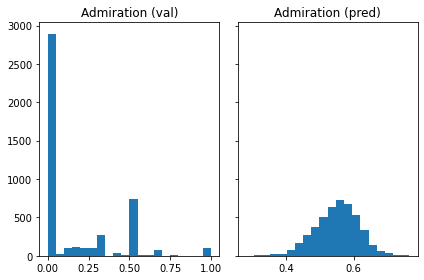

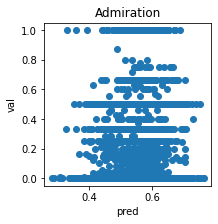

<Figure size 216x216 with 0 Axes>

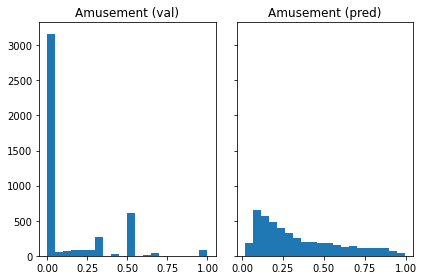

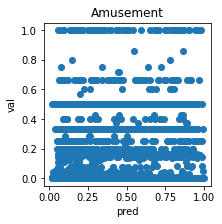

<Figure size 216x216 with 0 Axes>

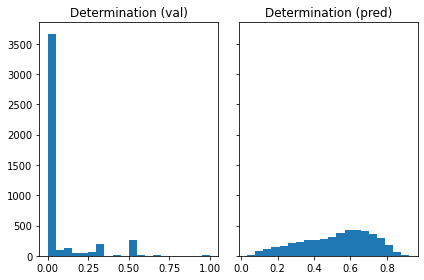

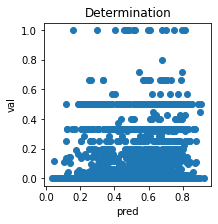

<Figure size 216x216 with 0 Axes>

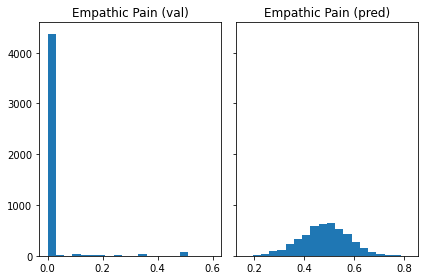

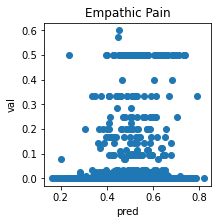

<Figure size 216x216 with 0 Axes>

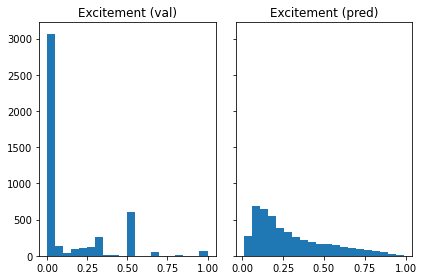

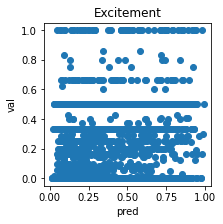

<Figure size 216x216 with 0 Axes>

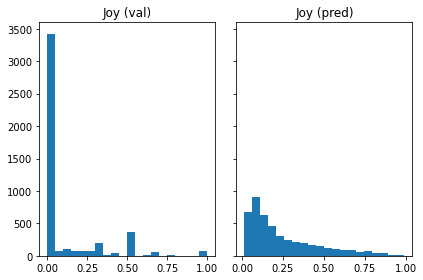

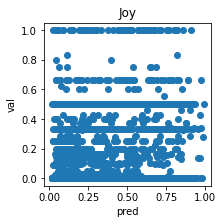

In [39]:
for i, cls in enumerate(classes):
    plt.figure(figsize=(3, 3))
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    axs[0].hist(y_val[:,i], bins=20)
    axs[0].set_title(cls+' (val)')
    axs[1].hist(y_val_preds[:,i], bins=20)
    axs[1].set_title(cls+' (pred)')

    plt.figure(figsize=(3, 3))
    plt.scatter(y_val_preds[:,i],y_val[:,i])
    plt.xlabel('pred')
    plt.ylabel('val')
    plt.title(cls)

<Figure size 216x216 with 0 Axes>

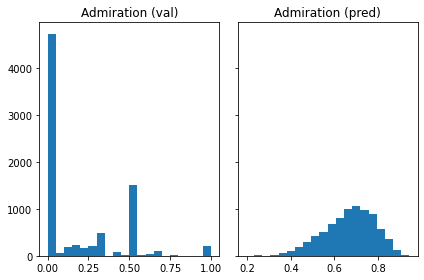

<Figure size 216x216 with 0 Axes>

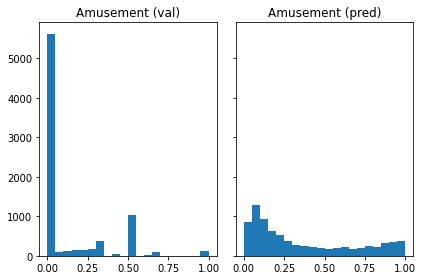

<Figure size 216x216 with 0 Axes>

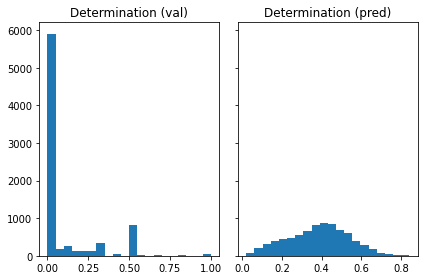

<Figure size 216x216 with 0 Axes>

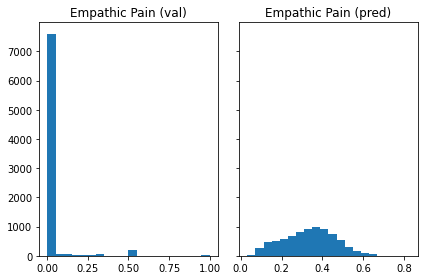

<Figure size 216x216 with 0 Axes>

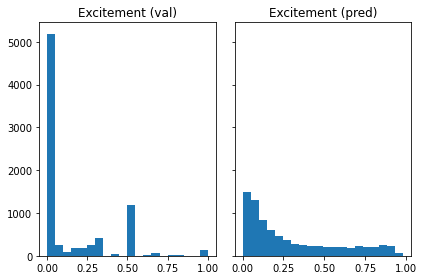

<Figure size 216x216 with 0 Axes>

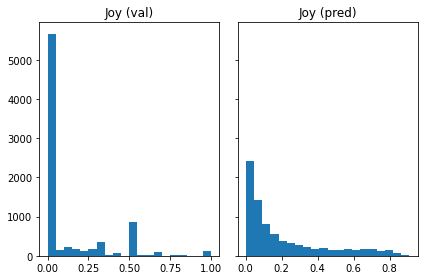

In [33]:
y_train_preds=mlpModel.predict(X_train,verbose=0)
for i, cls in enumerate(classes):
    plt.figure(figsize=(3, 3))
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    axs[0].hist(y_train[:,i], bins=20)
    axs[0].set_title(cls+' (val)')
    axs[1].hist(y_train_preds[:,i], bins=20)
    axs[1].set_title(cls+' (pred)')


best_vgaf
features: 0.16468719325142459, array([0.04719238, 0.23872681, 0.12715181, 0.10167664, 0.22254081,
       0.25083472])
agg features: 0.16581090507195018, array([0.05959792, 0.2307677 , 0.13180669, 0.07433949, 0.23725057,
       0.26110306])
scores: 0.15956704687617598, array([0.01631927, 0.23423282, 0.13149749, 0.07082677, 0.22806896,
       0.27645697])
agg scores: 0.16445071167985162, array([0.01858242, 0.24766241, 0.12774497, 0.07869363, 0.22775766,
       0.28626319])

       
mbf_va
features:0.15182967597822564, array([0.02151467, 0.22876023, 0.11397221, 0.0691848 , 0.22993618,
       0.24760996])
aggregate all features: 0.1645556550825007, array([0.05571004, 0.23802543, 0.13028415, 0.07030688, 0.23254514,
       0.26046229])
       
scores:0.16669173598326226, array([0.02758822, 0.23673681, 0.13362706, 0.08069747, 0.25155482,
       0.26994605])
aggregate all scores: (0.1732400927843647, array([0.02851866, 0.24981956, 0.13175185, 0.09749259, 0.25425177,
       0.27760613]))

ddamfnet
features:0.16198426966650922, array([0.01388326, 0.25147838, 0.12110723, 0.08410949, 0.23725866,
       0.2640686 ])
agg features: 0.16027512223492021, array([0.0594543 , 0.21693791, 0.13550432, 0.0687296 , 0.22447545,
       0.25654916])
scores:0.16402727920369453, array([0.01738167, 0.24622458, 0.12570119, 0.07402645, 0.24381048,
       0.27701931])
agg scores: 0.16844250684501985, array([0.03538154, 0.24612609, 0.1304421 , 0.06341882, 0.24262173,
       0.29266476])
       

ddamfnet_mtl
features:0.1628087073637761, array([0.02887615, 0.23853502, 0.128083  , 0.07613977, 0.23631758,
       0.26890072])
agg features: 0.17225771735921067, array([0.06134339, 0.23192009, 0.12823768, 0.10641768, 0.24464429,
       0.26098318])
scores: 0.1681939929777879, array([0.04078771, 0.23336167, 0.13869368, 0.08245851, 0.24289292,
       0.27096947])
agg scores:0.17033144680551396, array([0.02886761, 0.24497157, 0.12979594, 0.08784128, 0.24102297,
       0.2894893 ])
     
enet_b0_8_va_mtl
features: 0.16319175647904235, array([0.01617428, 0.23361139, 0.12388217, 0.10008462, 0.23394534,
       0.27145273])
agg features: (0.16725336033256263, array([0.03485187, 0.23179741, 0.13797108, 0.08773678, 0.24282352,
       0.26833951]))
scores:0.15836499311048943, array([0.02748861, 0.21146971, 0.1258152 , 0.08053375, 0.2273209 ,
       0.27756179])
agg scores: 0.15903670612437162, array([0.01880236, 0.23347567, 0.11501619, 0.07293681, 0.23117079,
       0.28281842])

mobile_vit
features: (0.16443273392150856, array([0.03788293, 0.23138948, 0.13868397, 0.07806633, 0.23335648,
       0.26721721]))
agg features: (0.16830869683333383, array([0.04331888, 0.24586312, 0.13468709, 0.0778735 , 0.23820341,
       0.26990619]))
scores: (0.16418244416927788, array([0.03213561, 0.24843837, 0.14901467, 0.0674399 , 0.23996759,
       0.24809851]))
agg scores:(0.17267761008941043, array([0.06208776, 0.25483363, 0.14304662, 0.06244557, 0.23984525,
       0.27380682]))
       
mobile_vit_orig_faces
agg scores: 0.17534107901477416, array([0.04539285, 0.26071049, 0.12750846, 0.08337933, 0.25092688,
       0.28412847])
       
       
mbf_vggface2_orig_faces
features: 0.07342328092964157, array([0.02346451, 0.05420641, 0.06448213, 0.08374254, 0.10532716,
       0.10931693])
aff features: 0.09717403864507052, array([0.03742797, 0.10086592, 0.0981474 , 0.09717746, 0.13195505,
       0.11747044])


all frames:
mobile vit features: (0.017115893185091147, array([0.05163362, 0.00402961, 0.00614032, 0.00229844, 0.02800543,
       0.01058794]))
       
audio
agg features: (0.2361361954257474, array([0.30001496, 0.1883828 , 0.2457414 , 0.31087313, 0.22221633,
       0.14958856]))
        
ensemble
audio agg features+ 
eri_mbf_va_face_images
mbf_va agg features: (0.28981449809217746, array([0.30411956, 0.30041602, 0.25837018, 0.3147965 , 0.31599936,
       0.24518537]))
       
#mbf va
w=0.1
y_ensemble=w*y_val_preds+(1-w)*y_val_preds_audio

#y_ensemble[:,2]=y_val_preds_audio[:,2]
#y_ensemble[:,3]=y_val_preds_audio[:,3]

w=0.4
y_ensemble[:,-1]=w*y_val_preds[:,-1]+(1-w)*y_val_preds_audio[:,-1]
#(0.29894266463043945, array([0.30411956, 0.30041602, 0.25837018, 0.3147965 , 0.31599936,       0.29995437]))



+mobilevit:
0.1 (0.2828523451828629, array([0.30110888, 0.29684512, 0.25949711, 0.30738044, 0.31708184,
       0.21520069]))
w=0.1
y_ensemble=w*y_val_preds+(1-w)*y_val_preds_audio

y_ensemble[:,3]=y_val_preds_audio[:,3]

w=0.5
y_ensemble[:,-1]=w*y_val_preds[:,-1]+(1-w)*y_val_preds_audio[:,-1]
#(0.2981795621039914, array([0.30110888, 0.29684512, 0.25949711, 0.31087313, 0.31708184, 0.3036713 ]))


ddamfn_va
0.1 (0.28359835070967354, array([0.3022263 , 0.29957365, 0.23646923, 0.30028883, 0.31403546,
       0.24899663]))
#ddamfnet
w=0.1
y_ensemble=w*y_val_preds+(1-w)*y_val_preds_audio

y_ensemble[:,2]=y_val_preds_audio[:,2]
y_ensemble[:,3]=y_val_preds_audio[:,3]

w=0.4
y_ensemble[:,-1]=w*y_val_preds[:,-1]+(1-w)*y_val_preds_audio[:,-1]

print(mean_pearsons(y_ensemble,y_val))
#(0.2952040356818089, array([0.3022263 , 0.29957365, 0.2457414 , 0.31087313, 0.31403546, 0.29877427]))

<ipython-input-38-5104b2b09224>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(3, 3))


<Figure size 216x216 with 0 Axes>

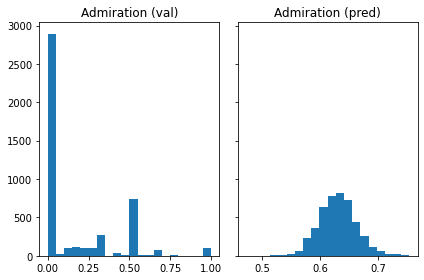

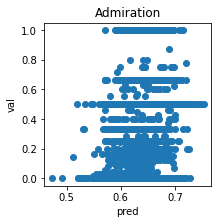

<Figure size 216x216 with 0 Axes>

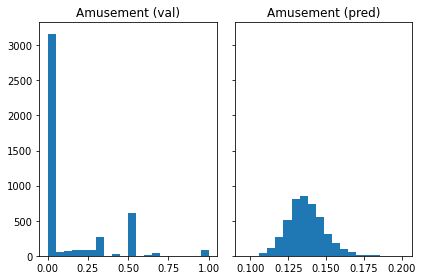

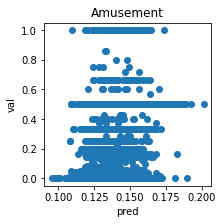

<Figure size 216x216 with 0 Axes>

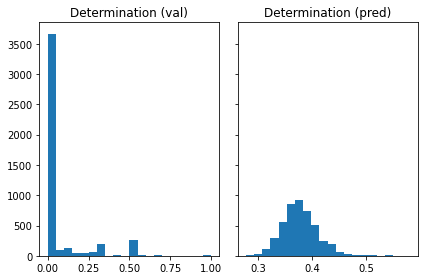

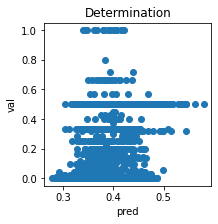

<Figure size 216x216 with 0 Axes>

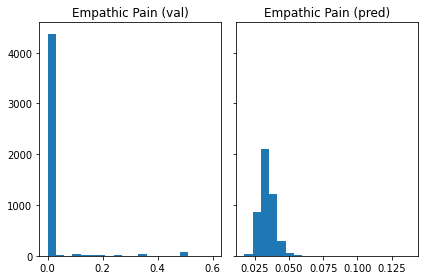

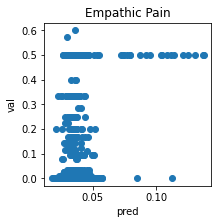

<Figure size 216x216 with 0 Axes>

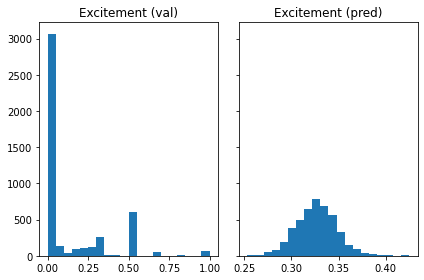

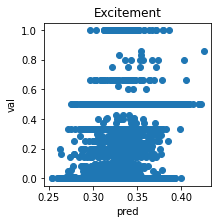

<Figure size 216x216 with 0 Axes>

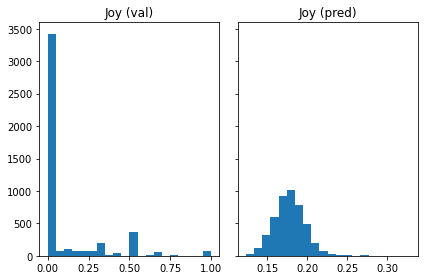

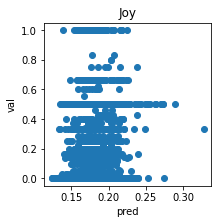

<Figure size 216x216 with 0 Axes>

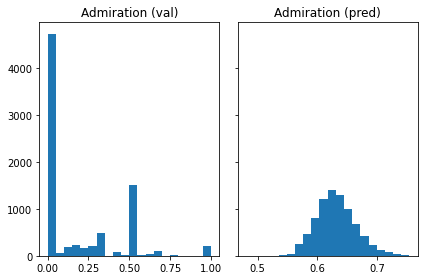

<Figure size 216x216 with 0 Axes>

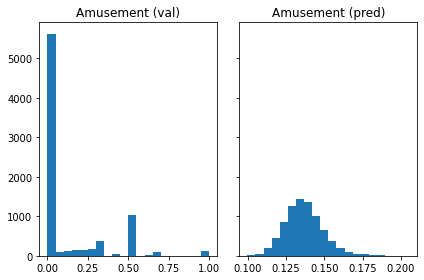

<Figure size 216x216 with 0 Axes>

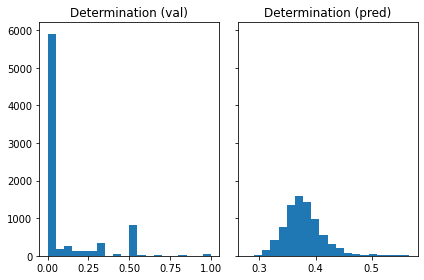

<Figure size 216x216 with 0 Axes>

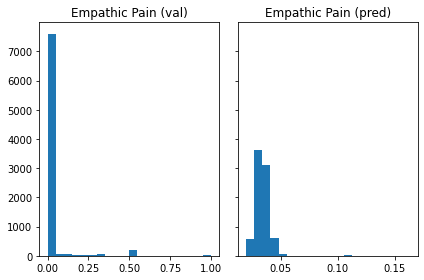

<Figure size 216x216 with 0 Axes>

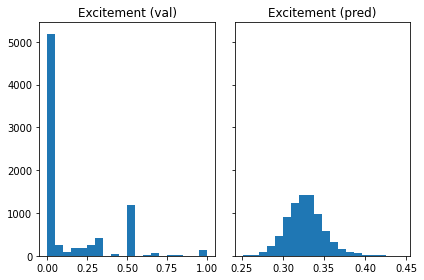

<Figure size 216x216 with 0 Axes>

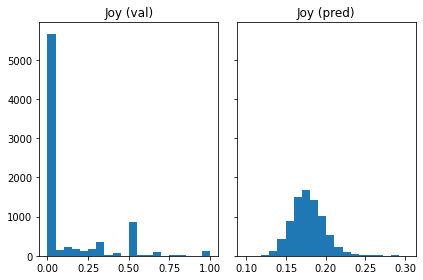

In [38]:
#Audio
for i, cls in enumerate(classes):
    plt.figure(figsize=(3, 3))
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    axs[0].hist(y_val[:,i], bins=20)
    axs[0].set_title(cls+' (val)')
    axs[1].hist(y_val_preds[:,i], bins=20)
    axs[1].set_title(cls+' (pred)')

    plt.figure(figsize=(3, 3))
    plt.scatter(y_val_preds[:,i],y_val[:,i])
    plt.xlabel('pred')
    plt.ylabel('val')
    plt.title(cls)
    
y_train_preds=mlpModel.predict(X_train,verbose=0)
for i, cls in enumerate(classes):
    plt.figure(figsize=(3, 3))
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    axs[0].hist(y_train[:,i], bins=20)
    axs[0].set_title(cls+' (val)')
    axs[1].hist(y_train_preds[:,i], bins=20)
    axs[1].set_title(cls+' (pred)')


# Save test results 

In [24]:
def get_test_video_features(videoname2features):
    X=[]
    for videoname in videoname2features:
        features=videoname2features[videoname]

        mean_features=features.mean(axis=0)
        std_features=features.std(axis=0)
        min_features=features.min(axis=0)
        max_features=features.max(axis=0)
        aggregated_feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)
        #aggregated_feature=mean_features

        X.append(aggregated_feature)
    X=np.array(X)
    print(X.shape)
    return X

In [101]:
X_test=get_test_video_features(videoname2scores_test)
y_test_preds=mlpModel.predict(X_test,verbose=0)
print(y_test_preds.shape)

(4586, 40)
(4586, 6)


In [28]:
X_audio_test=get_test_video_features(videoname2audio_features_test)
y_test_audio_preds=mlpModel.predict(X_audio_test,verbose=0)
print(y_test_audio_preds.shape)

(4586, 6)


In [52]:
#mbf va
w=0.1
y_ensemble=w*y_test_preds+(1-w)*y_test_audio_preds

#y_ensemble[:,2]=y_test_audio_preds[:,2]
#y_ensemble[:,3]=y_test_audio_preds[:,3]

w=0.4
y_ensemble[:,-1]=w*y_test_preds[:,-1]+(1-w)*y_test_audio_preds[:,-1]

print(y_ensemble)

[[0.4900853  0.18769468 0.1107658  0.07411952 0.1295931  0.31471333]
 [0.46249324 0.18448764 0.123752   0.06644058 0.12972072 0.30980292]
 [0.43635917 0.15393153 0.13985907 0.0826392  0.10105472 0.23562363]
 ...
 [0.47143847 0.15335515 0.11553539 0.06589058 0.12406084 0.23210227]
 [0.49563345 0.23212674 0.10952677 0.0529507  0.14789248 0.45930958]
 [0.4395843  0.20130783 0.11465646 0.04543256 0.16921626 0.53058743]]


In [72]:
#mobilevit
w=0.1
y_ensemble=w*y_test_preds+(1-w)*y_test_audio_preds

y_ensemble[:,3]=y_test_audio_preds[:,3]

w=0.4
y_ensemble[:,-1]=w*y_test_preds[:,-1]+(1-w)*y_test_audio_preds[:,-1]

print(y_ensemble)

[[0.4764402  0.16222474 0.11267997 0.06543092 0.11425896 0.27271718]
 [0.4463017  0.1858146  0.12318463 0.03853837 0.11992976 0.3112323 ]
 [0.42441052 0.15228902 0.13503066 0.04854969 0.0983649  0.25195074]
 ...
 [0.4573025  0.1512935  0.11363418 0.0356353  0.11630695 0.24457934]
 [0.4749427  0.20056097 0.11918769 0.04558285 0.12102737 0.34596974]
 [0.42152154 0.17093337 0.12249492 0.03619546 0.14776582 0.40528202]]


In [104]:
#ddamfnet
w=0.1
y_ensemble=w*y_test_preds+(1-w)*y_test_audio_preds

y_ensemble[:,2]=y_test_audio_preds[:,2]
y_ensemble[:,3]=y_test_audio_preds[:,3]

w=0.4
y_ensemble[:,-1]=w*y_test_preds[:,-1]+(1-w)*y_test_audio_preds[:,-1]

print(y_ensemble)

[[0.4888609  0.19192505 0.0720555  0.06543092 0.13774614 0.37444824]
 [0.4513509  0.18847406 0.08493616 0.03853837 0.13655794 0.35755914]
 [0.42719418 0.1548291  0.08851245 0.04854969 0.10329178 0.23074332]
 ...
 [0.4608904  0.14542416 0.06549436 0.0356353  0.12120492 0.21933019]
 [0.48574778 0.23193245 0.08611117 0.04558285 0.15967399 0.49751943]
 [0.4304653  0.20841119 0.08957669 0.03619546 0.18445885 0.6005862 ]]


In [42]:
OUTDIR=os.path.join(DATA_DIR,'test_data','outputs')
print(OUTDIR)
if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)

/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/ERI/test_data/outputs


In [105]:
#with open(os.path.join(OUTDIR,'1_mbf_va.txt'), 'w') as f:
#with open(os.path.join(OUTDIR,'2_mbf_va_train_val.txt'), 'w') as f:
#with open(os.path.join(OUTDIR,'4_mobilevit_train_val.txt'), 'w') as f:
with open(os.path.join(OUTDIR,'5_ddamnfn_va_train_val.txt'), 'w') as f:
    f.write('Filename,Admiration,Amusement,Determination,Empathic Pain,Excitement,Joy\n')
    for videoname,y in zip(videoname2scores_test,y_ensemble):
        f.write(videoname+','+','.join(map(str,y))+'\n')

In [56]:
with open(os.path.join(OUTDIR,'3_mbf_va_train_val_single.txt'), 'w') as f:
    f.write('Filename,Admiration,Amusement,Determination,Empathic Pain,Excitement,Joy\n')
    for videoname,y in zip(videoname2scores_test,y_test_preds):
        f.write(videoname+','+','.join(map(str,y))+'\n')

In [106]:
with open(os.path.join(OUTDIR,'6_wav2vec2.txt'), 'w') as f:
    f.write('Filename,Admiration,Amusement,Determination,Empathic Pain,Excitement,Joy\n')
    for videoname,y in zip(videoname2scores_test,y_test_audio_preds):
        f.write(videoname+','+','.join(map(str,y))+'\n')